# Sprint25 GAN

# 【問題1】ノイズの作成
Generatorに入力するノイズを作成するcreate_noiseメソッドを完成させてください。このメソッドは「ミニバッチのサイズ×潜在変数の次元数」のndarrayを返すことが求められます。np.random.normalを用いてください。

# 【問題2】Discriminatorの作成
DiscriminatorのModelインスタンスを作成するdiscriminator_modelメソッドを完成させてください。


画像を受け取り、2値分類を行うモデルです。出力層を合わせて3層程度の全結合層としてください。中間層の活性化関数はLeakyReLUを用いてください。

# 【問題3】GeneratorとDiscriminatorを繋げる
Generatorを学習させるにはGeneratorとDiscriminatorを繋げたModelインスタンスを作成する必要があります。そのためのadversarial_modelメソッドを完成させてください。


雛形のこのメソッド中ではself.generatorとself.discriminatorをDenseクラスなどと同様に利用することが可能です。

# 【問題4】学習
VanillaGANを学習し、生成された画像を確認してください。本物に近い生成を行うには時間がかかりますので、2000ステップ程度で学習が進んでいることを見てください。


学習過程では例えば次のような画像が生成されます。

In [ ]:
# !pip install tensorflow==1.14
# !pip install keras==2.2.5

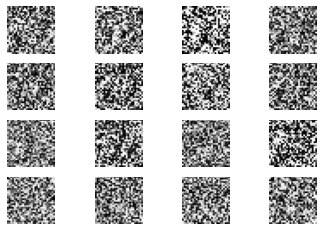

1900 step, [D loss: 0.693443] [G loss: 0.693364]


In [ ]:
from keras.datasets import mnist
from keras.layers import BatchNormalization, Dense, Flatten, Input, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import os


class VanillaGAN():
    """
    VanillaGAN
    Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., and Bengio, Y. (2014). Generative adversarial nets. In NIPS’2014. https://arxiv.org/pdf/1406.2661.pdf
    Parameters
    ----------------
    img_shape : tuple of int
        生成する画像の形。順番は（縦, 幅, チャンネル数）。(default : (28, 28, 1))
    noise_dim : int
        潜在変数の次元数 (default : 100)
    """
    def __init__(self, img_shape=(28, 28, 1), noise_dim=100):
        self.img_shape = img_shape
        self.noise_dim = noise_dim
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
        self.compile_models()

    def compile_models(self):
        """
        Modelインスタンスのコンパイルを行う
        """
        self.discriminator = self.discriminator_model()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])
        
        self.adversarial = self.adversarial_model() #adversarial_model呼び出し
        self.adversarial.compile(loss='binary_crossentropy', optimizer=self.optimizer)

    def generator_model(self):
        """
        GeneratorのModelインスタンスを作る
        """
        noise = Input(shape=(self.noise_dim,))

        x = Dense(128, input_dim=self.noise_dim)(noise)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(1024)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(np.prod(self.img_shape), activation='tanh')(x)
        gen_img = Reshape(self.img_shape)(x)

        return Model(inputs=noise, outputs=gen_img)

    def discriminator_model(self):
        """
        DiscriminatorのModelインスタンスを作る
        """
        img = Input(shape=self.img_shape)

        # Functional APIでのモデル作成
        x = Flatten(input_shape=self.img_shape)(img)

        # 問題2で作成
        x = Dense(1024)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(128)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        validity = Dense(1, activation='sigmoid')(x) #sigmoid
        
        # validity = Reshape(self.img_shape)(x)

        return Model(inputs=img, outputs=validity)

    def adversarial_model(self):
        """
        DiscriminatorとGeneratorを繋げたModelインスタンスを作る
        """
        self.generator = self.generator_model()
        self.discriminator.trainable = False
        noise = Input(shape=(self.noise_dim,))

        # 問題3で作成
        # ジェネレータ―の入力
        x = self.generator(noise)

        # ディスクリミネータの入力
        validity = self.discriminator(x)

        return Model(inputs=noise, outputs=validity)

    def create_noise(self, batch_size):
        """
        Parameters
        ----------------
        batch_size : int
            ミニバッチのサイズ
        Returns
        ----------------
        noise : ndarray, shape(batch_size, noise_dim)
            ノイズ（ミニバッチのサイズ×ノイズの次元数）
        """
        # 問題1
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim)) #平均1、標準偏差1のガウス分布乱数

        return noise

    def train(self, n_steps, batch_size=128, sample_interval=100):
        """
        VanillaGANを学習する
        Parameters
        ----------------
        n_steps : int
            学習するステップ数   
        batch_size : int
            バッチサイズ (default : 128)
        sample_interval : int
            サンプル画像を生成して表示・保存するステップの間隔 (default : 100)
        """
        os.makedirs("gen_imgs", exist_ok=True)
        (X_train, y_train), (_, _) = mnist.load_data()
        n_iters = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        X_train = X_train/127.5 - 1.
        
        X_train = np.expand_dims(X_train, axis=3)
        # X_train = X_train.reshape(60000, 784)
        

        real_label = np.ones((batch_size, 1)) #本物ラベル
        fake_label = np.zeros((batch_size, 1)) #偽物ラベル

        for step in range(n_steps):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_imgs = X_train[idx]

            noise = self.create_noise(batch_size)

            # train the discriminator
            gen_imgs = self.generator.predict(noise) #1. Generatorにノイズを入力し、データを生成する

            #train_on_batch:単一バッチデータにつき一度の勾配更新
            d_loss_real = self.discriminator.train_on_batch(real_imgs, real_label) #2. Discriminatorに訓練データと本物であるというラベルを入力し、Discriminatorの重みを更新する
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake_label) #3. Discriminatorに生成データと偽物であるというラベルを入力し、Discriminatorの重みを更新する
            d_loss = (d_loss_real[0] + d_loss_fake[0])/2

            # train the generator
            g_loss = self.adversarial.train_on_batch(noise, real_label) # 4. Discriminatorに生成データと本物であるというラベルを入力し、Generatorの重みを更新する
            if step % sample_interval == 0:
                self.show_sample_images(step) #第二引数にiがついてた
                print ("%d step, [D loss: %f] [G loss: %f]" % (step, d_loss, g_loss))

    def show_sample_images(self, step):
        """
        サンプル画像を生成して表示・保存する
        Parameters:
        ----------------
        step : int
            ステップの番号
        """
        n_sample_rows, n_sample_cols = (4, 4)
        noise = self.create_noise(n_sample_rows*n_sample_cols)
        gen_imgs = self.generator.predict(noise)
        gen_imgs = gen_imgs/2 + 0.5
        fig, axs = plt.subplots(n_sample_rows, n_sample_cols)
        count = 0
        for row in range(n_sample_rows):
            for col in range(n_sample_cols):
                axs[row, col].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                axs[row, col].axis('off')
                count += 1
        display.clear_output(wait=True)
        display.display(plt.gcf())
        fig.savefig("gen_imgs/%d.png" % (step))
        plt.close()

vanilla_gan = VanillaGAN()
vanilla_gan.train(n_steps=2000, batch_size=128)

# 【問題5】ConditionalGANの新規性の読解
ConditionalGANの論文[2]を読み、GANにどのような要素を足したものなのかを文章で説明してください。

# 【問題6】ConditionalGANの実装
課題の前半で完成させたVanillaGANクラスを元に問題5で読み解いた要素を加え、ConditionalGANクラスを作成してください。


完成後、ConditionalGANで生成した画像を確認してください。

In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs=20000, batch_size=32, sample_interval=200)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_464 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_369 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_465 (Dense)            (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_370 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_466 (Dense)            (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_371 (LeakyReLU)  (None, 512)              

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.696344, acc.: 17.19%] [G loss: 0.685669]


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


ストリーミング出力は最後の 5000 行に切り捨てられました。
15000 [D loss: 0.640209, acc.: 60.94%] [G loss: 0.735927]
15001 [D loss: 0.683220, acc.: 60.94%] [G loss: 0.734491]
15002 [D loss: 0.648858, acc.: 62.50%] [G loss: 0.779876]
15003 [D loss: 0.715160, acc.: 45.31%] [G loss: 0.761256]
15004 [D loss: 0.673235, acc.: 51.56%] [G loss: 0.768367]
15005 [D loss: 0.688335, acc.: 51.56%] [G loss: 0.788579]
15006 [D loss: 0.685038, acc.: 59.38%] [G loss: 0.844926]
15007 [D loss: 0.655993, acc.: 60.94%] [G loss: 0.798353]
15008 [D loss: 0.663482, acc.: 65.62%] [G loss: 0.767266]
15009 [D loss: 0.697345, acc.: 50.00%] [G loss: 0.816867]
15010 [D loss: 0.653510, acc.: 57.81%] [G loss: 0.776901]
15011 [D loss: 0.715584, acc.: 50.00%] [G loss: 0.746684]
15012 [D loss: 0.640807, acc.: 59.38%] [G loss: 0.697489]
15013 [D loss: 0.707500, acc.: 54.69%] [G loss: 0.786078]
15014 [D loss: 0.682956, acc.: 56.25%] [G loss: 0.795851]
15015 [D loss: 0.702561, acc.: 53.12%] [G loss: 0.773418]
15016 [D loss: 0.677355, acc.: 65.62%] [

In [ ]:
784/2

392.0

In [ ]:
ls

gen_imgs/  images  sample_data/
